In [2]:
import pandas as pd
import os
import torch
import json
from torchsummary import summary
from src.anti_spoof_predict import AntiSpoofPredict
import torch.nn as nn
from tqdm import tqdm
import time 
from src.generate_patches import CropImage
import torchvision.transforms as trans
import cv2
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import AnovaRM
import numpy as np
from PIL import Image

In [7]:
model_path = "resources/anti_spoof_models/2.7_80x80_MiniFASNetV2.pth"
device_id = 0

model = AntiSpoofPredict(device_id)
model._load_model(model_path)

summary(model.model, input_size=(3, 80, 80))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 40, 40]             864
       BatchNorm2d-2           [-1, 32, 40, 40]              64
             PReLU-3           [-1, 32, 40, 40]              32
        Conv_block-4           [-1, 32, 40, 40]               0
            Conv2d-5           [-1, 32, 40, 40]             288
       BatchNorm2d-6           [-1, 32, 40, 40]              64
             PReLU-7           [-1, 32, 40, 40]              32
        Conv_block-8           [-1, 32, 40, 40]               0
            Conv2d-9          [-1, 103, 40, 40]           3,296
      BatchNorm2d-10          [-1, 103, 40, 40]             206
            PReLU-11          [-1, 103, 40, 40]             103
       Conv_block-12          [-1, 103, 40, 40]               0
           Conv2d-13          [-1, 103, 20, 20]             927
      BatchNorm2d-14          [-1, 103,

In [3]:
class CustomModel(nn.Module):
    def __init__(self, original_model):
        super(CustomModel, self).__init__()
        # all the layers except the final linear layer:
        self.features = nn.Sequential(*list(original_model.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        return x
    
def copy_weights(original_model, custom_model):
    original_state_dict = original_model.state_dict()
    custom_state_dict = custom_model.state_dict()

    for name, param in original_state_dict.items():
        if name in custom_state_dict:
            custom_state_dict[name].copy_(param)

# custom_model = CustomModel(model.model).to(model.device)


In [4]:
image_cropper = CropImage()

def dropout_embeddings(image_path):
    custom_model = CustomModel(model.model).to(model.device)
    copy_weights(model.model, custom_model)

    test_transform = trans.Compose([
        trans.ToTensor(),
    ])

    image = cv2.imread(image_path)
    image_bbox = model.get_bbox(image)
    param = {
        "org_img": image,
        "bbox": image_bbox,
        "scale": 2.7,
        "out_w": 80,
        "out_h": 80,
        "crop": True,
    }
    image = image_cropper.crop(**param)
    image = test_transform(image).unsqueeze(0).to(model.device)

    with torch.no_grad():
        custom_model.eval()
        embeddings = custom_model(image)

    return embeddings

embedding = dropout_embeddings(image_path="/Users/kassymmukhanbetiyar/Development/Verigram/CelebA/archive/CelebA_Spoof_/CelebA_Spoof/Data/test/3613/spoof/511091.png")
print(embedding.shape)
print(embedding)

torch.Size([1, 128])
tensor([[-0.5530, -0.1861, -0.5238,  0.0263, -0.0210, -0.4939,  0.7082, -0.0656,
         -0.6221,  0.1802, -0.6143,  0.1209,  0.4925, -0.1230,  0.1557, -0.5914,
         -0.1970,  0.3124, -0.7351,  0.4267, -0.1467,  0.2020,  0.0757, -0.5251,
          0.5206,  0.3818,  0.1793,  0.5681, -0.5799, -0.6396, -0.0362, -0.5388,
         -0.8899,  0.6188, -0.7247,  0.5952,  0.5187, -0.6310, -0.0278, -0.7215,
         -0.3514,  0.0693,  0.8269,  0.0046,  0.4669, -0.1549,  0.1544, -0.6820,
         -0.7751,  0.0504,  0.1457, -0.1915,  0.5415, -0.2041, -0.5544, -0.4898,
          0.5475,  0.1925,  0.5171,  0.4991, -0.6959,  0.3940,  0.1677,  0.7807,
          0.0647, -0.1602,  0.6706, -0.6477, -0.5295, -0.4900,  0.1102, -0.7994,
         -0.7105,  0.6295,  0.5544,  0.1375, -0.7189, -0.5055, -0.6161, -0.7123,
         -0.4600,  0.7404,  0.7110, -0.6491,  0.6706,  0.7298,  0.7955, -0.1347,
          0.6435,  0.1739,  0.6934, -0.5031, -0.5326,  0.4917,  0.1031,  0.5840,
       

In the following snippet you can stop prematurely to get embeddings for a small number of images.

In [ ]:
def fill_dropout_csv(model_path="resources/anti_spoof_models/2.7_80x80_MiniFASNetV2.pth", checkpoint_path="dropout_embeddings.csv"):
    # Get the number of processed images
    processed_count = 0
    image_dir = "/Users/kassymmukhanbetiyar/Development/Verigram/CelebA/archive/CelebA_Spoof_/CelebA_Spoof/"
    if os.path.isfile(checkpoint_path):
        processed_count = sum(1 for _ in open(checkpoint_path)) - 1  # Subtract 1 to exclude the header row

    # Get the remaining image paths to process
    with open('test_label.json', 'r') as file:
        data = json.load(file)


    remaining_image_names = list(data.keys())[processed_count:]

    # Create a new DataFrame for the newly processed images
    new_embeddings_df = pd.DataFrame(columns=range(1, 129))

    total_iterations = len(remaining_image_names)
    progress_bar = tqdm(total=total_iterations, ncols=80, dynamic_ncols=True, smoothing=0.5)
    # Initialize start time
    start_time = time.time()

    # Iterate over the remaining image paths and fill in the embeddings
    for i, image_name in enumerate(remaining_image_names, start=processed_count + 1):
        image_path = image_dir + image_name
        embeddings = dropout_embeddings(image_path)

        # Add the embeddings to the new DataFrame
        new_embeddings_df.loc[image_name] = embeddings.reshape(1, -1).tolist()[0]  # Reshape to (1, 128)

        # Append the new embeddings to the existing DataFrame and CSV file every 250 iterations
        if i % 250 == 0 or i == len(data):
            new_embeddings_df.to_csv(checkpoint_path, mode='a')
            new_embeddings_df = pd.DataFrame(columns=range(1, 129))
            # Update progress bar
            progress_bar.update(250 if i % 250 == 0 else i % 250)
            progress_bar.set_postfix({'Remaining': f'{total_iterations - i}', 'Elapsed': f'{time.time() - start_time:.2f}s'})
    return checkpoint_path

fill_dropout_csv()

In [8]:
df = pd.read_csv("dataset.csv", index_col=0)
df.rename(columns={'Real': 'Prediction', '40':'SpoofType', '41':'Illumination', '42':'Environment', '43':'Spoof'}, inplace=True)
# the prediction by silent face takes values 0-2. Gotta convert it.
df['Prediction'] = df['Prediction'].replace({0.0: 1, 1.0: 0, 2.0: 1})
df['Prediction'] = df['Prediction'].astype(int)

with open('test_label.json', 'r') as file:
    data = json.load(file)

# duplicate_indexes = df.duplicated()
# Load embeddings from CSV file
embeddings = pd.read_csv('dropout_embeddings.csv', index_col=0)
embeddings_head = embeddings[:1000].copy()
df = df.drop_duplicates()
common_index = df.index.intersection(embeddings.index)
df = df.loc[common_index]
embeddings = embeddings.loc[common_index]
# df = df.sort_index()
# embeddings = embeddings.sort_index()
pd.testing.assert_series_equal(df.index.to_series(), embeddings.index.to_series())


In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

accuracy = accuracy_score(df['Spoof'], df['Prediction'])
precision = precision_score(df['Spoof'], df['Prediction'])
recall = recall_score(df['Spoof'], df['Prediction'])
f1 = f1_score(df['Spoof'], df['Prediction'])
roc_auc = roc_auc_score(df['Spoof'], df['Prediction'])


# Print the evaluation metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')
print(f'Roc Auc score: {roc_auc}')

Accuracy: 0.6799844690351388
Precision: 0.8934516188037315
Recall: 0.5799002730618544
F1 score: 0.7033117350611952
Roc Auc score: 0.7245668162929656


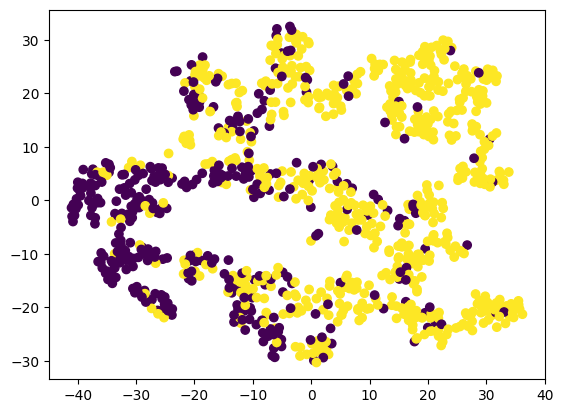

In [9]:
# Create t-SNE object
tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto")

# Fit t-SNE model to embeddings
tsne_embeddings_head = tsne.fit_transform(embeddings_head)

# Visualize t-SNE embeddings
plt.scatter(tsne_embeddings_head[:, 0], tsne_embeddings_head[:, 1], c = df['Spoof'][:1000], cmap = 'viridis')
plt.show()

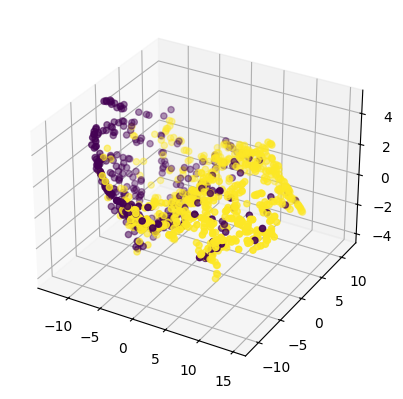

In [4]:
# Create t-SNE object with 3 components
tsne3 = TSNE(n_components=3, perplexity=30, learning_rate="auto")

# Fit t-SNE model to embeddings
tsne3_embeddings = tsne3.fit_transform(embeddings_head)

# Visualize t-SNE embeddings in 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne3_embeddings[:, 0], tsne3_embeddings[:, 1], tsne3_embeddings[:, 2], c = df['Spoof'][:1000], cmap = 'viridis')
plt.show()

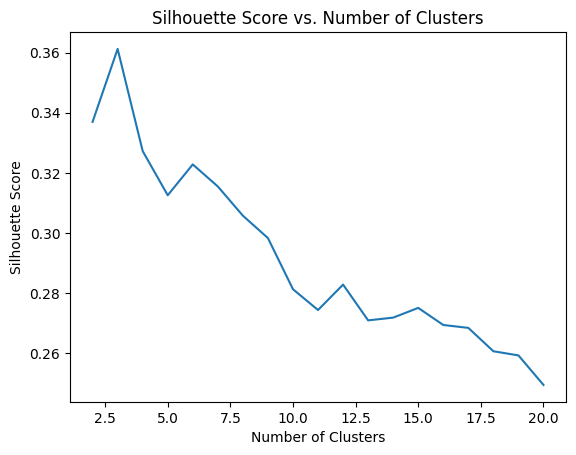

In [80]:
# Define the range of number of clusters_head to try
min_clusters = 2
max_clusters = 20
n_clusters_range = range(min_clusters, max_clusters+1)

# Compute the silhouette scores for each number of clusters_head
silhouette_scores = []
for n_clusters in n_clusters_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    clusters_head = gmm.fit_predict(embeddings)
    score = silhouette_score(embeddings, clusters_head)
    silhouette_scores.append(score)

# Plot the silhouette scores as a function of the number of clusters_head
plt.plot(n_clusters_range, silhouette_scores)
plt.xlabel('Number of clusters_head')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of clusters_head')
plt.show()

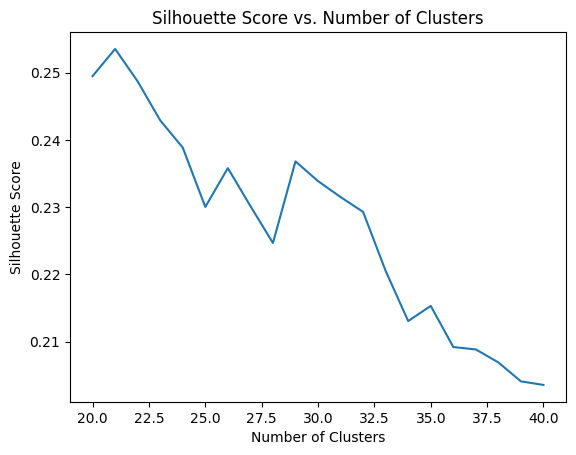

In [36]:
# Define the range of number of clusters_head to try
min_clusters = 20
max_clusters = 40
n_clusters_range = range(min_clusters, max_clusters+1)

# Compute the silhouette scores for each number of clusters_head
silhouette_scores = []
for n_clusters in n_clusters_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    clusters_head = gmm.fit_predict(embeddings)
    score = silhouette_score(embeddings, clusters_head)
    silhouette_scores.append(score)

# Plot the silhouette scores as a function of the number of clusters_head
plt.plot(n_clusters_range, silhouette_scores)
plt.xlabel('Number of clusters_head')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of clusters_head')
plt.show()

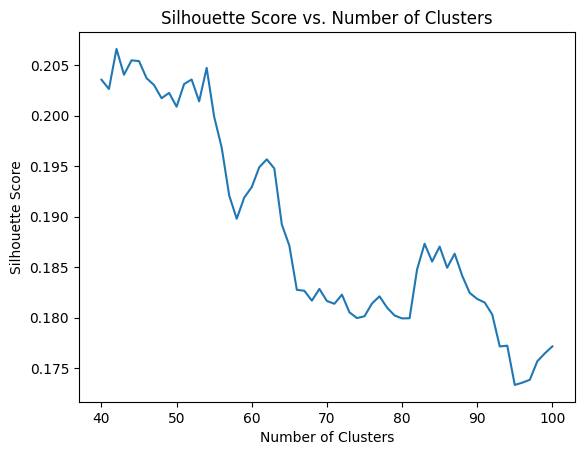

In [37]:
# Define the range of number of clusters_head to try
min_clusters = 40
max_clusters = 100
n_clusters_range = range(min_clusters, max_clusters+1)

# Compute the silhouette scores for each number of clusters_head
silhouette_scores = []
for n_clusters in n_clusters_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    clusters_head = gmm.fit_predict(embeddings)
    score = silhouette_score(embeddings, clusters_head)
    silhouette_scores.append(score)

# Plot the silhouette scores as a function of the number of clusters_head
plt.plot(n_clusters_range, silhouette_scores)
plt.xlabel('Number of clusters_head')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of clusters_head')
plt.show()

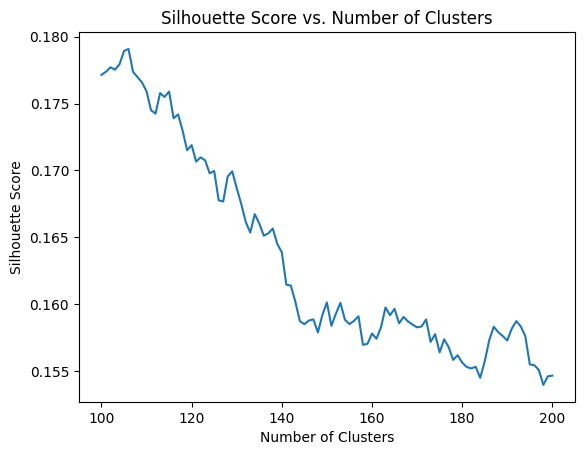

In [38]:
# Define the range of number of clusters_head to try
min_clusters = 100
max_clusters = 200
n_clusters_range = range(min_clusters, max_clusters+1)

# Compute the silhouette scores for each number of clusters_head
silhouette_scores = []
for n_clusters in n_clusters_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    clusters_head = gmm.fit_predict(embeddings)
    score = silhouette_score(embeddings, clusters_head)
    silhouette_scores.append(score)

# Plot the silhouette scores as a function of the number of clusters_head
plt.plot(n_clusters_range, silhouette_scores)
plt.xlabel('Number of clusters_head')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of clusters_head')
plt.show()

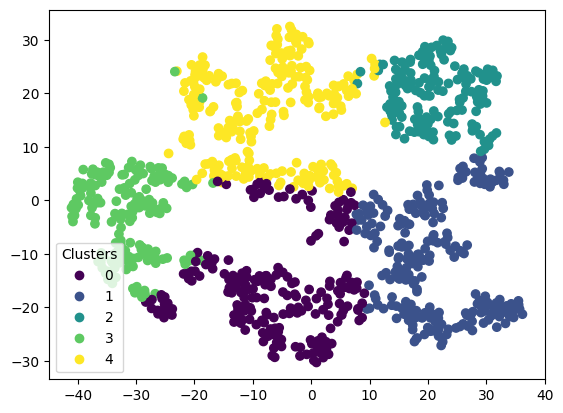

In [25]:
# Fit t-SNE model to embeddings
tsne_embeddings_head = tsne.fit_transform(embeddings_head)

# Cluster embeddings using GMM
gmm = GaussianMixture(n_components=5, random_state=42)
clusters_head = gmm.fit_predict(embeddings_head)

# Visualize t-SNE embeddings with cluster labels
scatter = plt.scatter(tsne_embeddings_head[:, 0], tsne_embeddings_head[:, 1], c=clusters_head, cmap='viridis')
plt.legend(*scatter.legend_elements(), loc = "lower left", title = "Clusters")
plt.show()

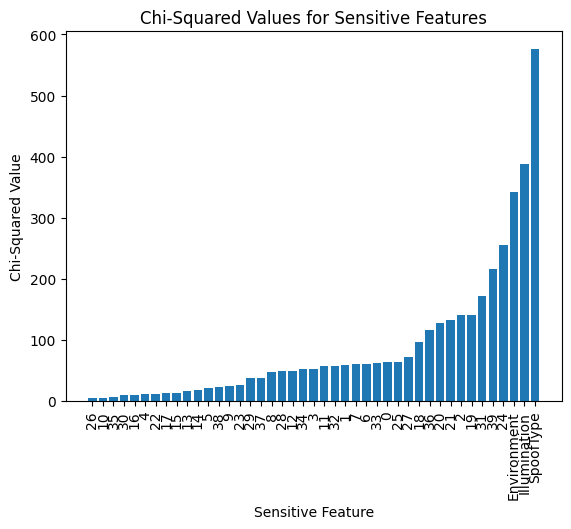

In [6]:
from scipy.stats import chi2_contingency

features = list(df)[:-3]
chi2_values = {}

for feature in features:
    contingency_table = pd.crosstab(df[feature][:1000], clusters_head)
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    # print()
    chi2_values[feature] = chi2

sorted_chi2 = sorted(chi2_values.items(), key = lambda x: x[1])
sorted_features = [pair[0] for pair in sorted_chi2]
sorted_chi2_values = [pair[1] for pair in sorted_chi2]
# create a bar plot
plt.bar(sorted_features, sorted_chi2_values)

# set the title and labels
plt.title('Chi-Squared Values for Sensitive Features')
plt.xlabel('Sensitive Feature')
plt.ylabel('Chi-Squared Value')

# rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# show the plot
plt.show()

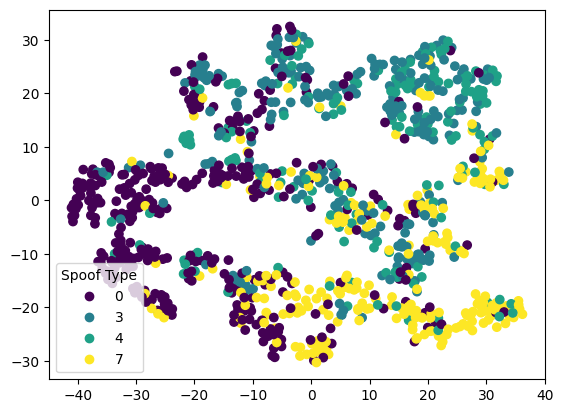

In [16]:
scatter = plt.scatter(tsne_embeddings_head[:, 0], tsne_embeddings_head[:, 1], c=df["SpoofType"][:1000], cmap='viridis')
legend = plt.legend(*scatter.legend_elements(), loc = "lower left", title = "Spoof Type")
plt.show()

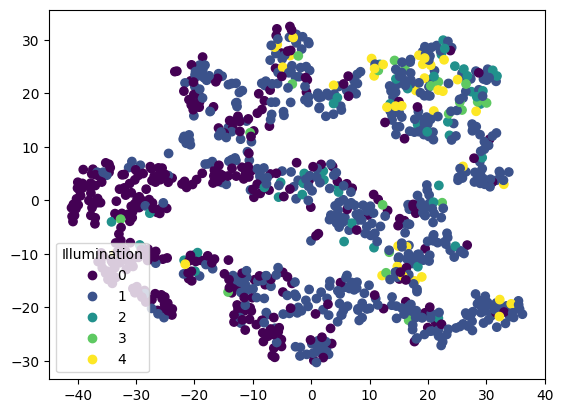

In [17]:
scatter = plt.scatter(tsne_embeddings_head[:, 0], tsne_embeddings_head[:, 1], c=df["Illumination"][:1000], cmap='viridis')
plt.legend(*scatter.legend_elements(), loc = "lower left", title = "Illumination")
plt.show()

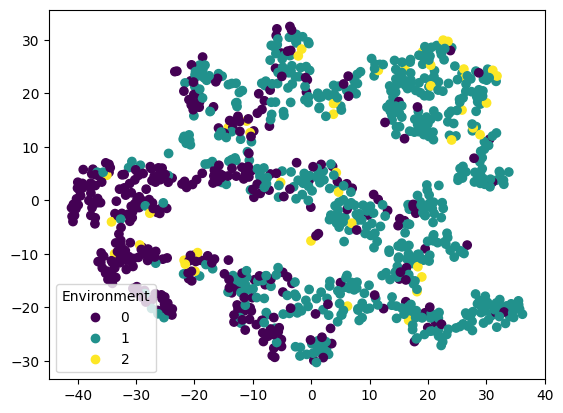

In [18]:
scatter = plt.scatter(tsne_embeddings_head[:, 0], tsne_embeddings_head[:, 1], c=df["Environment"][:1000], cmap='viridis')
plt.legend(*scatter.legend_elements(), loc = "lower left", title = "Environment")
plt.show()

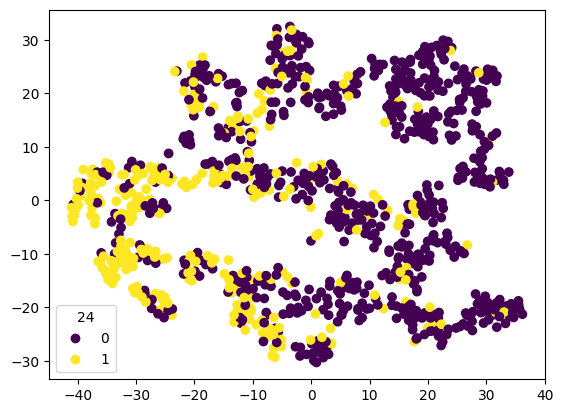

In [20]:
scatter = plt.scatter(tsne_embeddings_head[:, 0], tsne_embeddings_head[:, 1], c=df["24"][:1000], cmap='viridis')
plt.legend(*scatter.legend_elements(), loc = "lower left", title = "24")
plt.show()

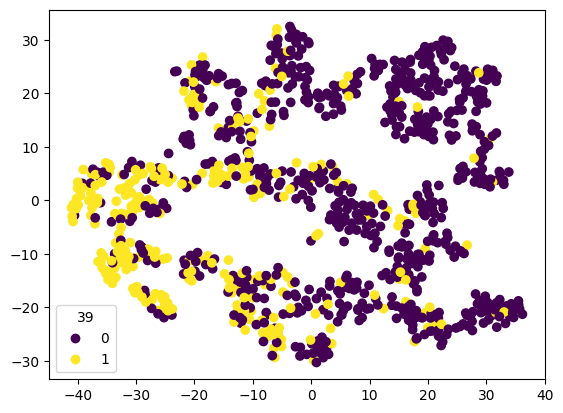

In [21]:
scatter = plt.scatter(tsne_embeddings_head[:, 0], tsne_embeddings_head[:, 1], c=df["39"][:1000], cmap='viridis')
plt.legend(*scatter.legend_elements(), loc = "lower left", title = "39")
plt.show()

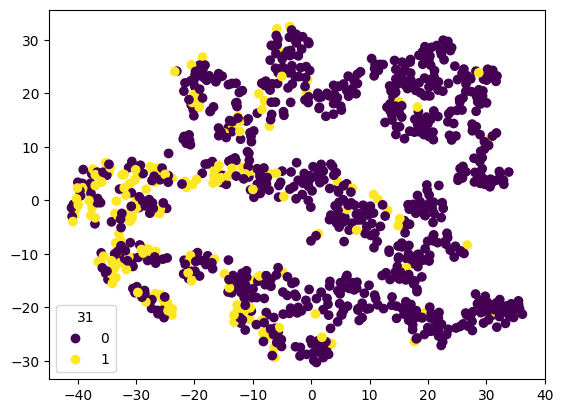

In [22]:
scatter = plt.scatter(tsne_embeddings_head[:, 0], tsne_embeddings_head[:, 1], c=df["31"][:1000], cmap='viridis')
plt.legend(*scatter.legend_elements(), loc = "lower left", title = "31")
plt.show()

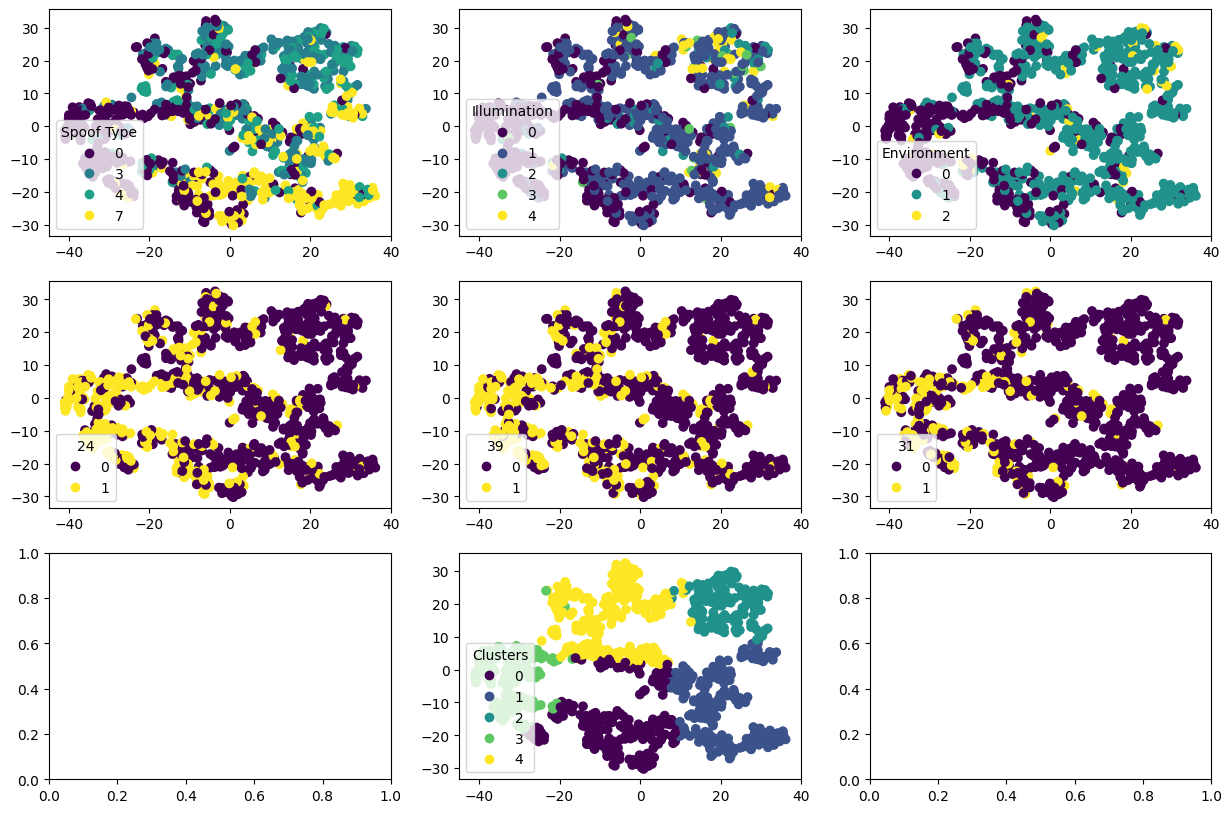

In [26]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

scatter1 = axs[0, 0].scatter(tsne_embeddings_head[:, 0], tsne_embeddings_head[:, 1], c=df["SpoofType"][:1000], cmap='viridis')
axs[0, 0].legend(*scatter1.legend_elements(), loc = "lower left", title = "Spoof Type")

scatter2 = axs[0, 1].scatter(tsne_embeddings_head[:, 0], tsne_embeddings_head[:, 1], c=df["Illumination"][:1000], cmap='viridis')
axs[0, 1].legend(*scatter2.legend_elements(), loc = "lower left", title = "Illumination")

scatter3 = axs[0, 2].scatter(tsne_embeddings_head[:, 0], tsne_embeddings_head[:, 1], c=df["Environment"][:1000], cmap='viridis')
axs[0, 2].legend(*scatter3.legend_elements(), loc = "lower left", title = "Environment")

scatter4 = axs[1, 0].scatter(tsne_embeddings_head[:, 0], tsne_embeddings_head[:, 1], c=df["24"][:1000], cmap='viridis')
axs[1, 0].legend(*scatter4.legend_elements(), loc = "lower left", title = "24")

scatter5 = axs[1, 1].scatter(tsne_embeddings_head[:, 0], tsne_embeddings_head[:, 1], c=df["39"][:1000], cmap='viridis')
axs[1, 1].legend(*scatter5.legend_elements(), loc = "lower left", title = "39")

scatter6 = axs[1, 2].scatter(tsne_embeddings_head[:, 0], tsne_embeddings_head[:, 1], c=df["31"][:1000], cmap='viridis')
axs[1, 2].legend(*scatter6.legend_elements(), loc = "lower left", title = "31")

scatter7 = axs[2, 1].scatter(tsne_embeddings_head[:, 0], tsne_embeddings_head[:, 1], c=clusters_head, cmap='viridis')
axs[2, 1].legend(*scatter.legend_elements(), loc = "lower left", title = "Clusters")

plt.show()

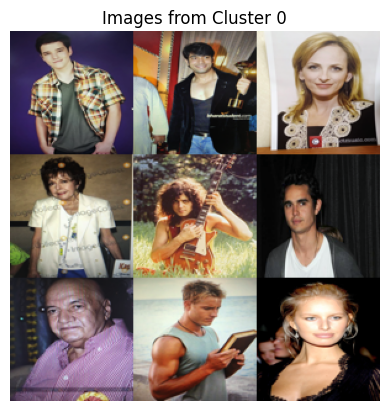

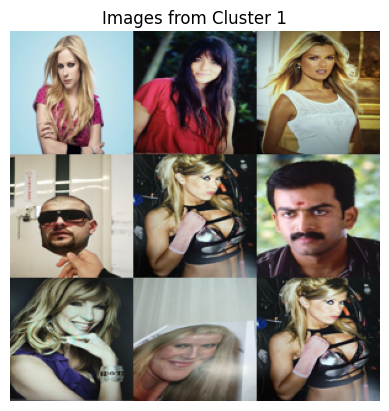

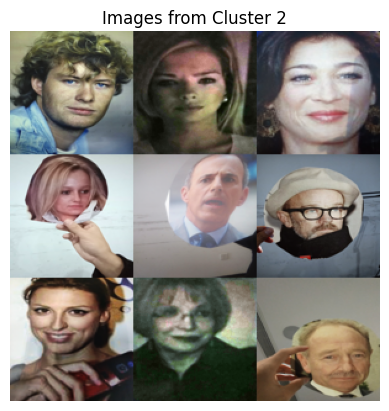

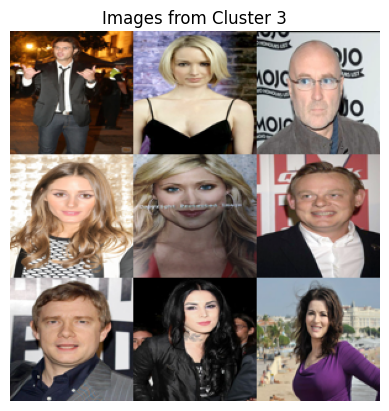

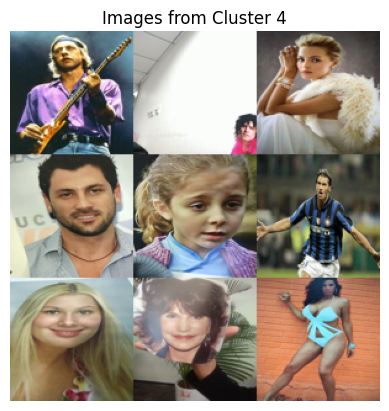

In [27]:
df_head = df[:1000].copy()
df_head["cluster"] = clusters_head
size = (100, 100)
np.random.seed(1234)


# Create a grid for each cluster and display them separately
for cluster_id, group in df_head.groupby('cluster'):
    # Select 9 images at random from the current cluster
    indices = np.random.choice(group.index, size=9, replace=False)

    # Load and resize the selected images
    images = []
    for path in indices:
        image_path = "/Users/kassymmukhanbetiyar/Development/Verigram/CelebA/archive/CelebA_Spoof_/CelebA_Spoof/"+path
        image = Image.open(image_path)
        image = image.resize(size)
        images.append(np.array(image))

    # Stack the resized images in a 3x3 grid
    grid = np.vstack([np.hstack(images[j:j+3]) for j in range(0, 9, 3)])

    # Display the resulting image
    plt.imshow(grid)
    plt.axis('off')
    plt.title(f'Images from Cluster {cluster_id}')
    plt.show()


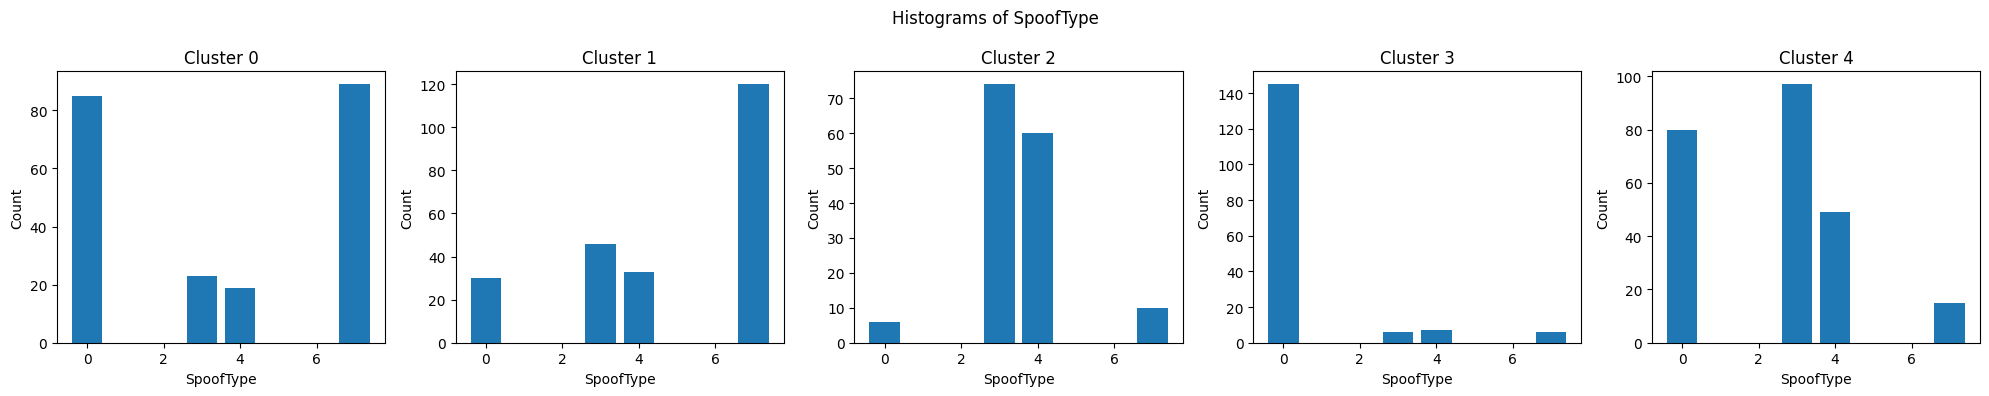

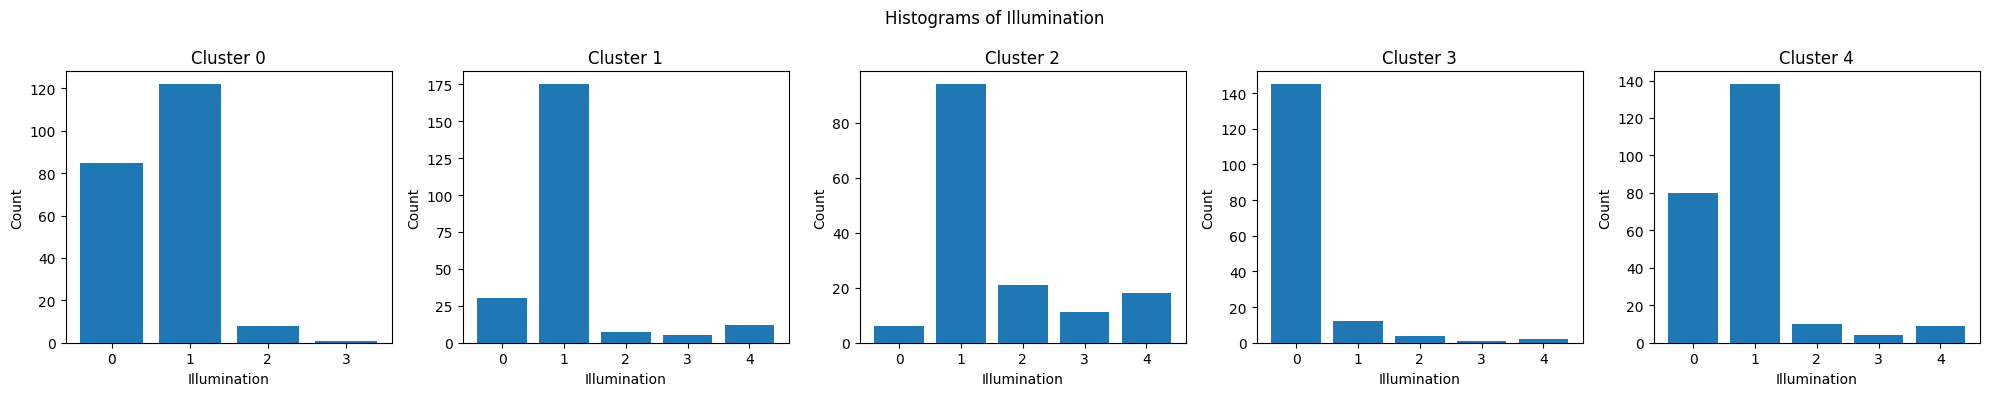

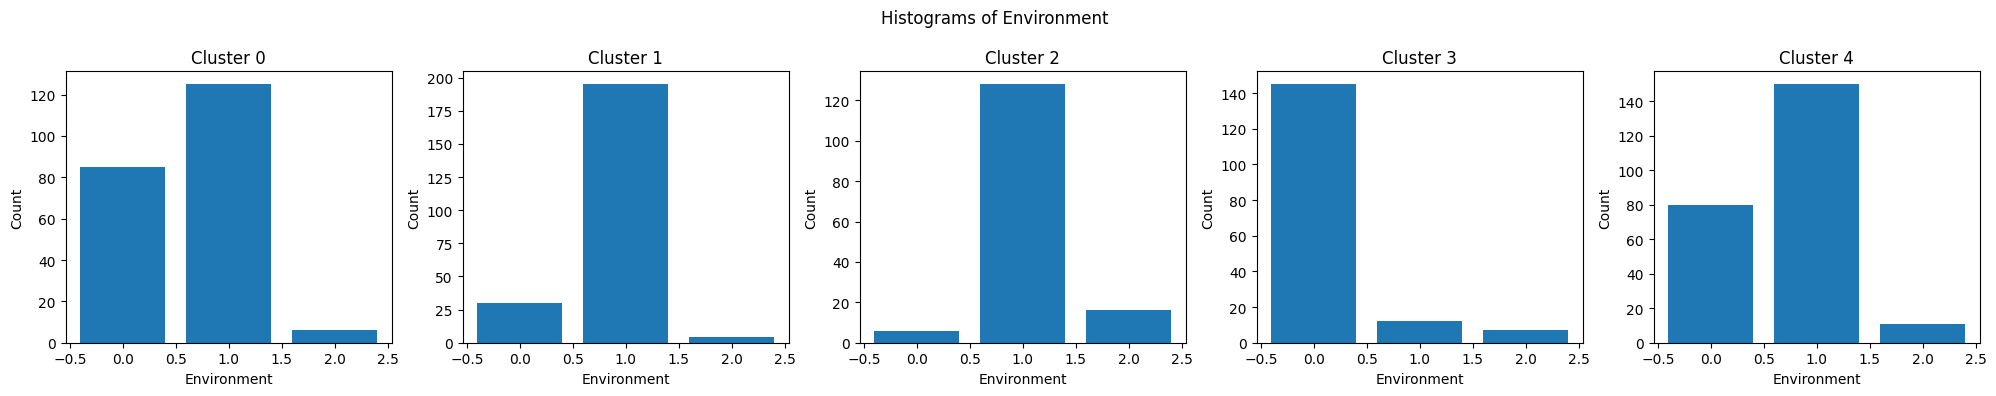

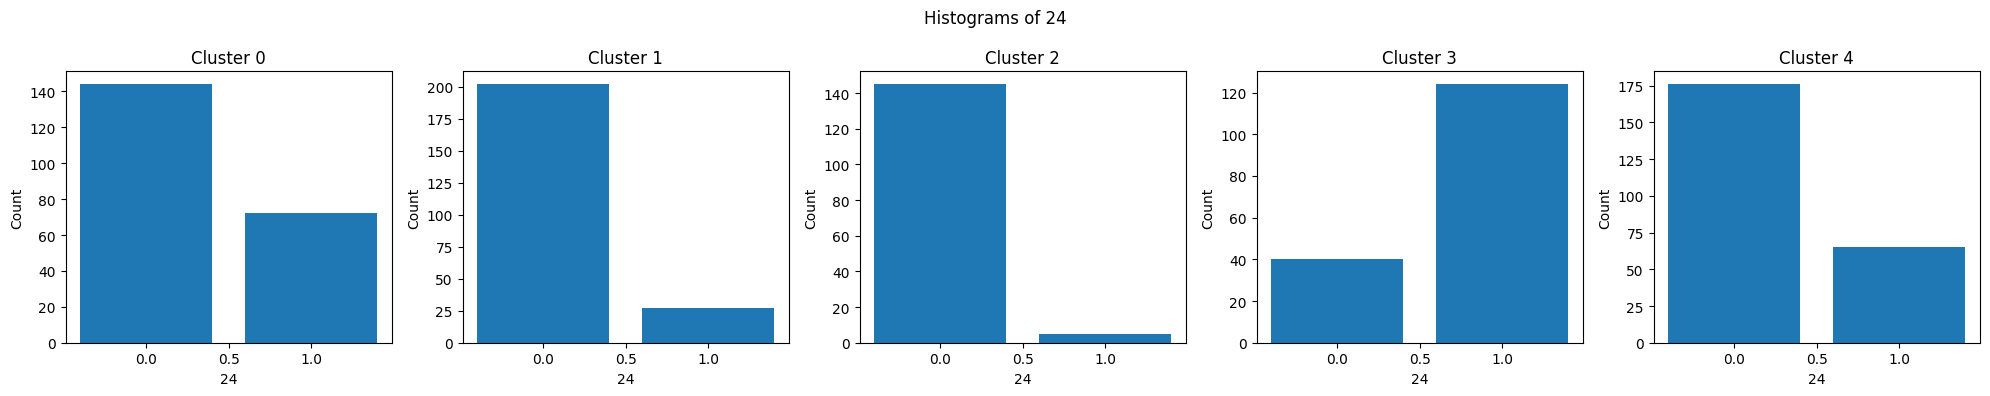

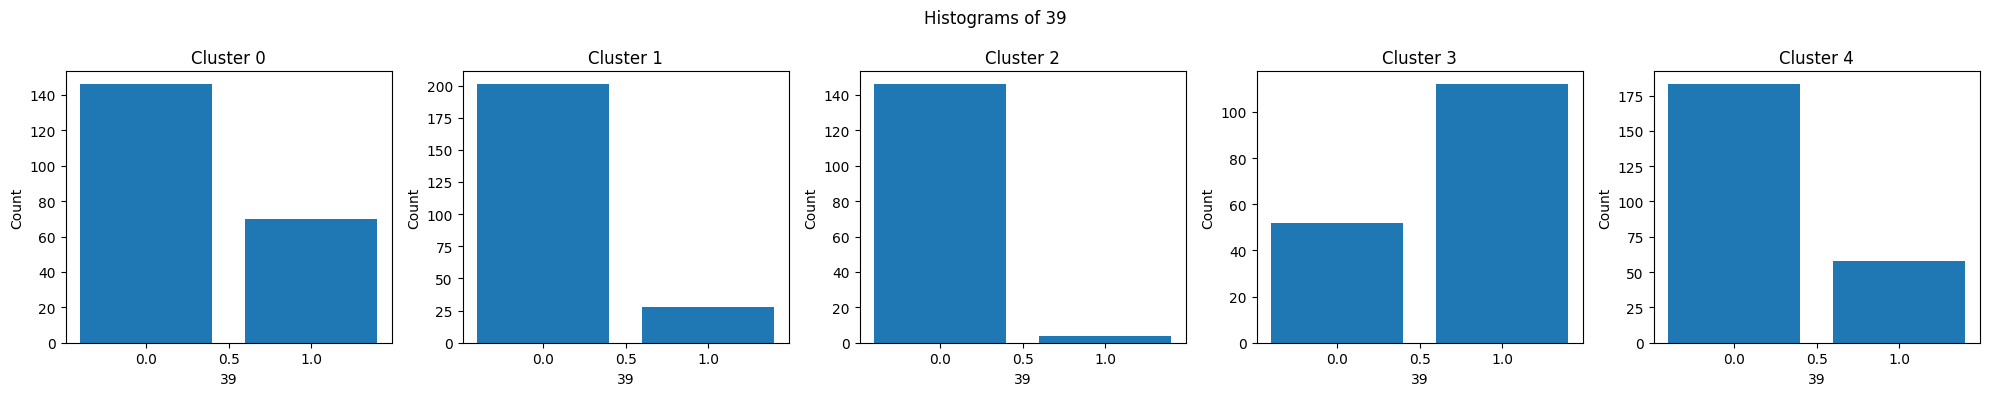

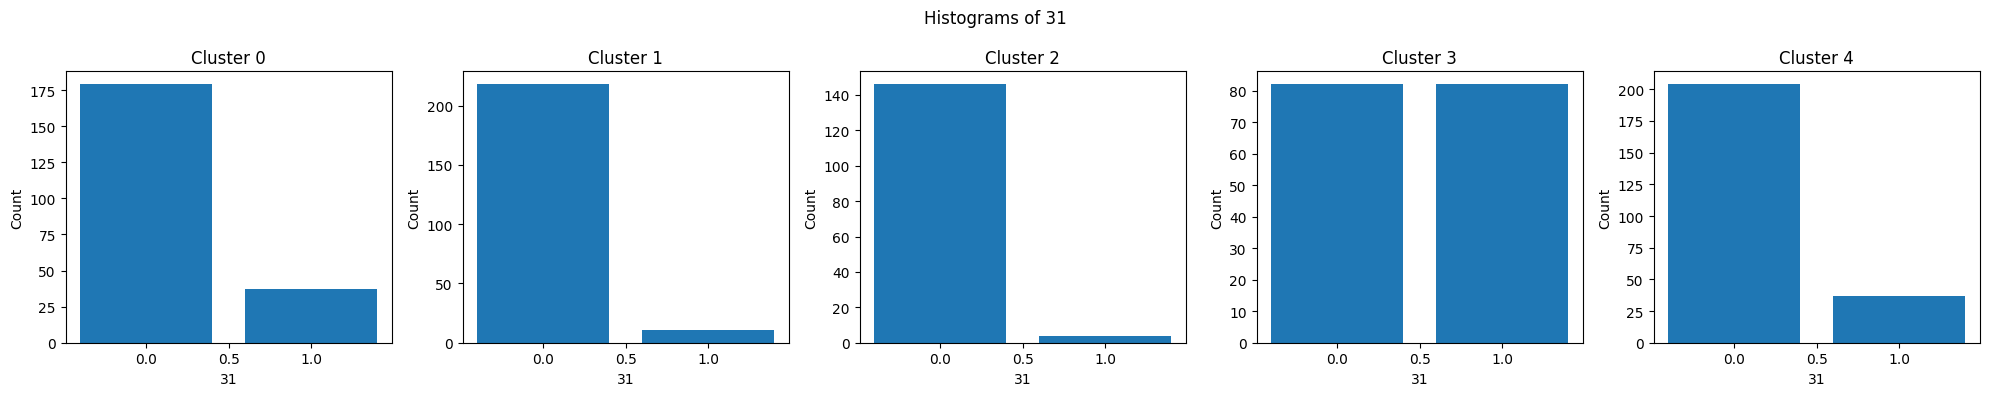

In [29]:
top_features = ["SpoofType", "Illumination", "Environment", "24", "39", "31"]
# Create a grid of histograms for each sensitive feature
for feature in top_features:
    # Create a subplot for each cluster
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))

    # Create a histogram for each cluster
    for cluster_id, group in df_head.groupby('cluster'):
        # Count the frequency of each value of the current feature in the current cluster
        counts = group[feature].value_counts()

        # Create a bar chart of the counts in the current subplot
        axs[cluster_id].bar(counts.index, counts.values)
        axs[cluster_id].set_xlabel(feature)
        axs[cluster_id].set_ylabel("Count")
        axs[cluster_id].set_title(f"Cluster {cluster_id}")

    # Add a title to the overall plot
    plt.suptitle(f"Histograms of {feature}")

    # Adjust the layout of the subplots
    plt.tight_layout()

    # Display the overall plot
    plt.show()

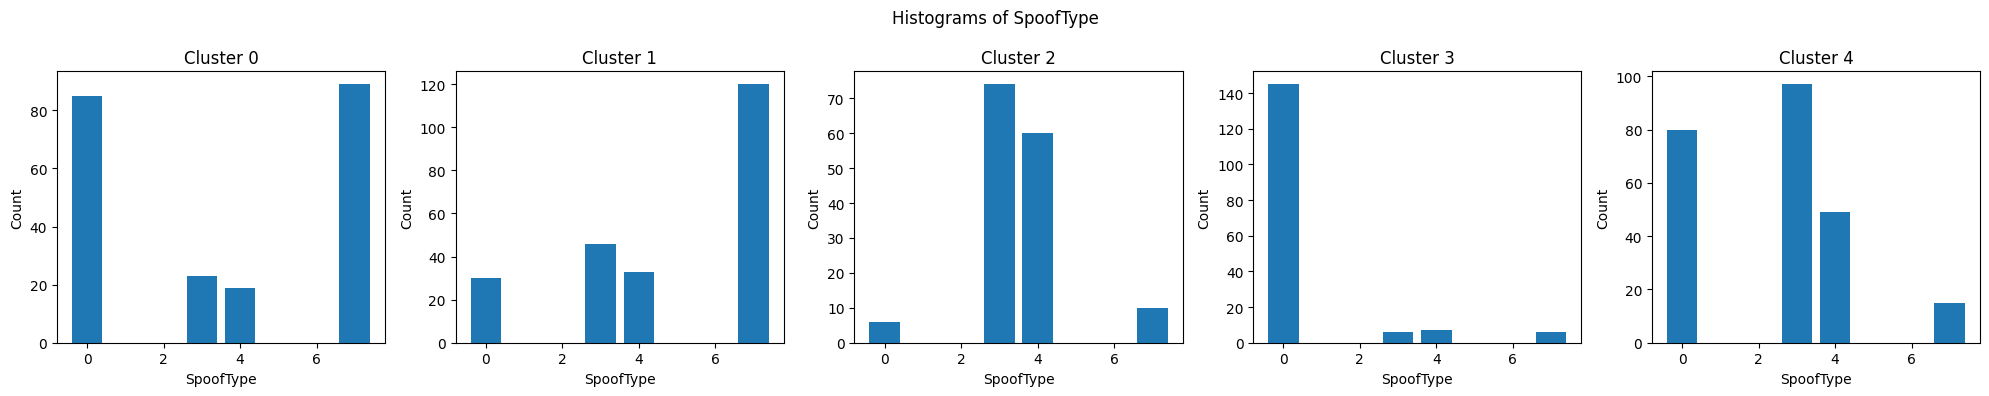

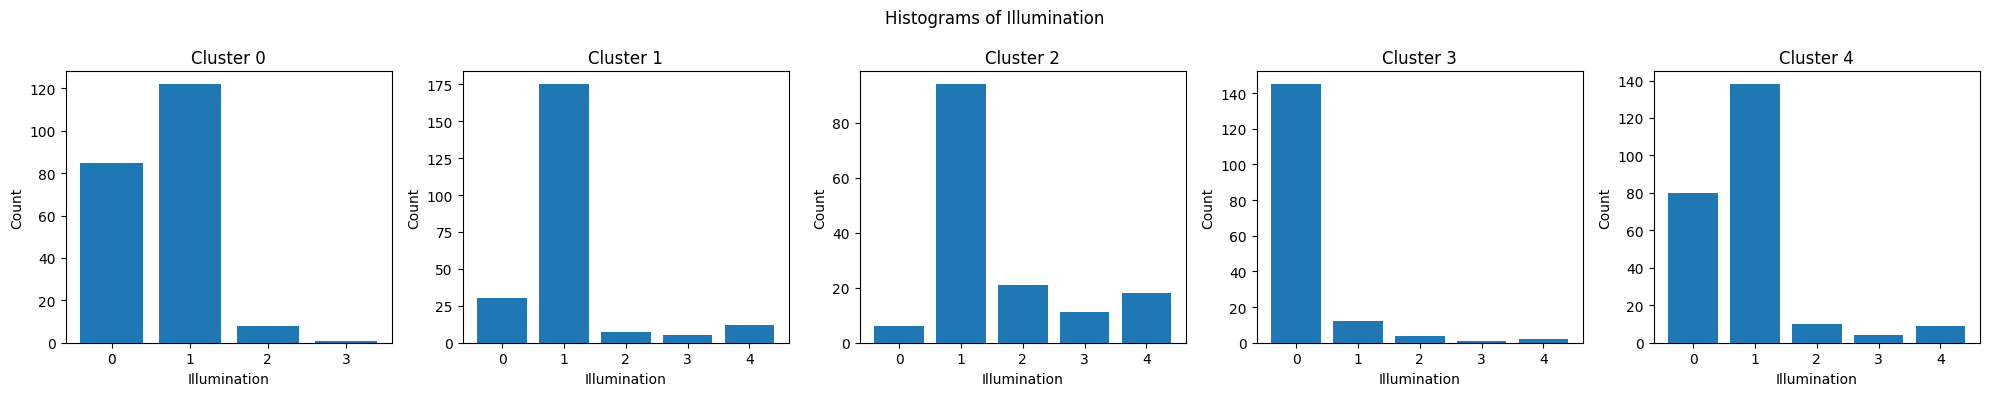

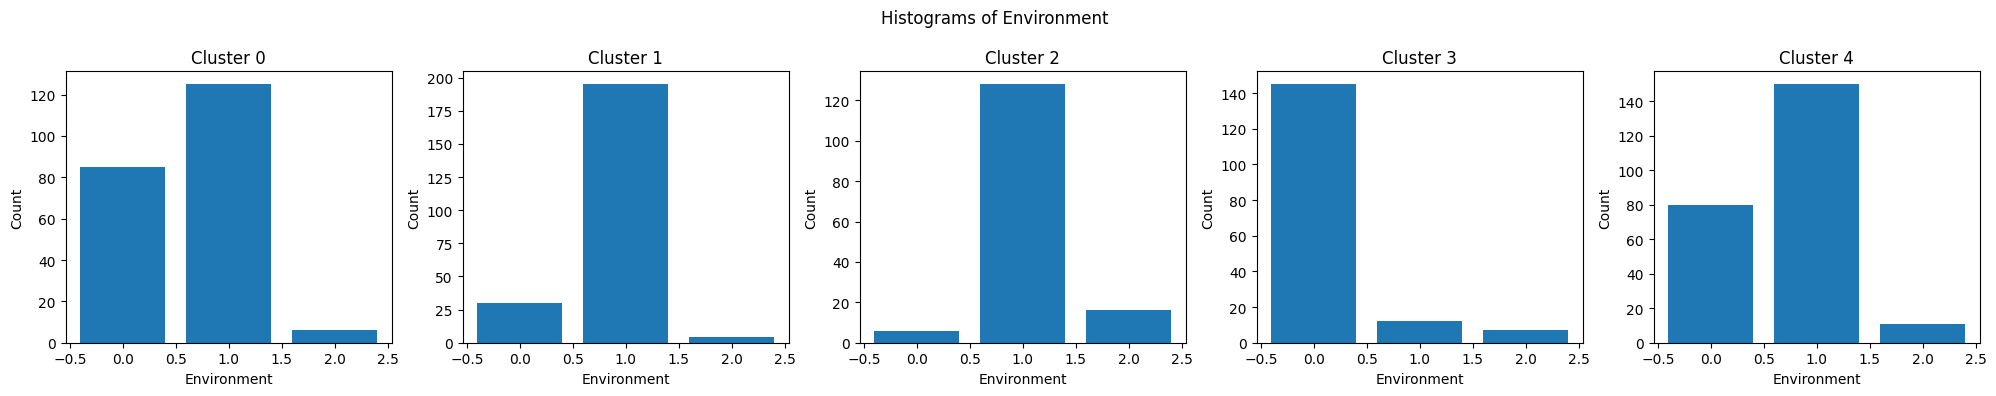

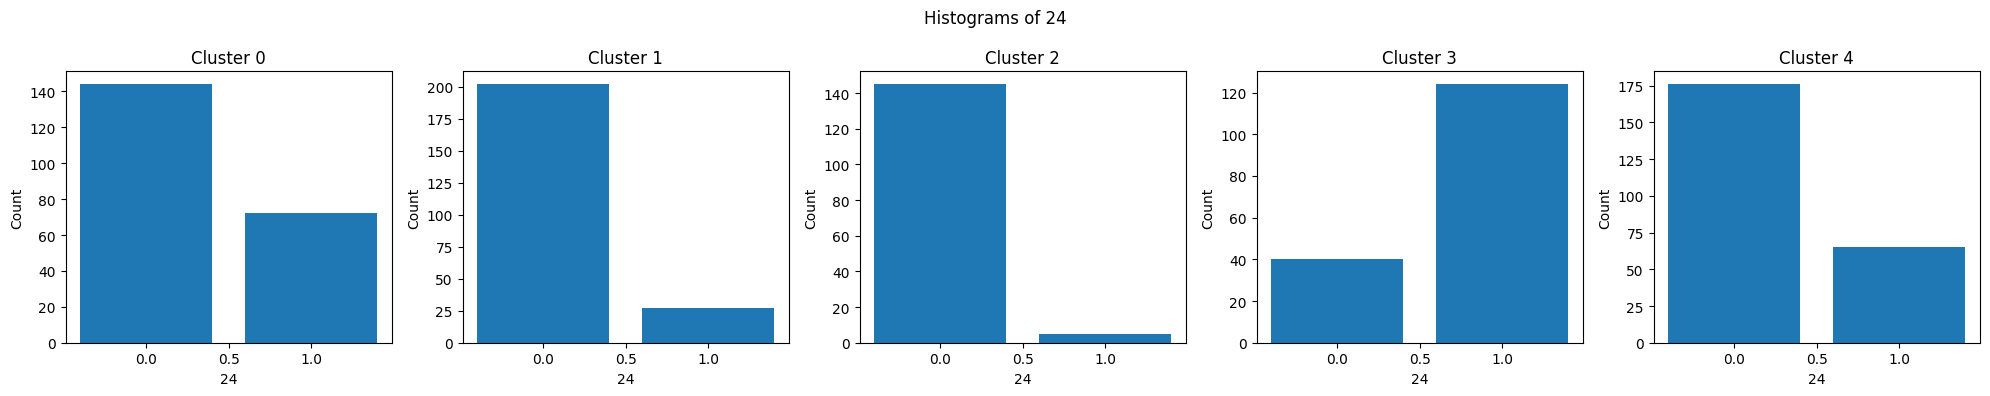

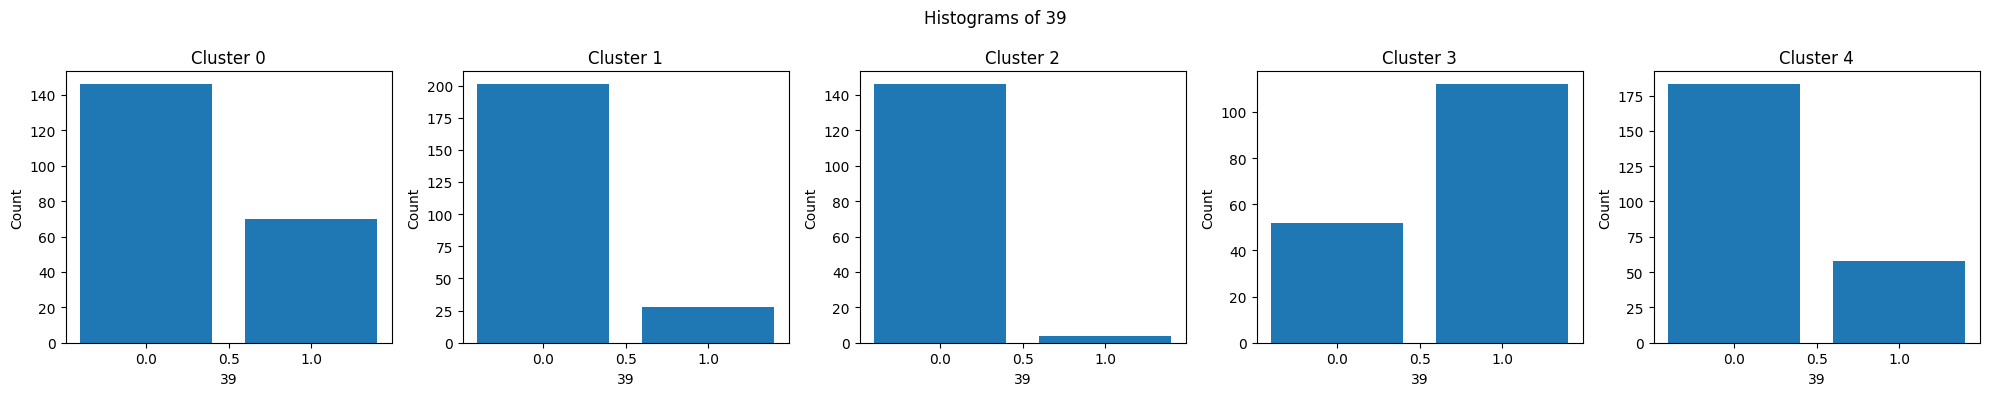

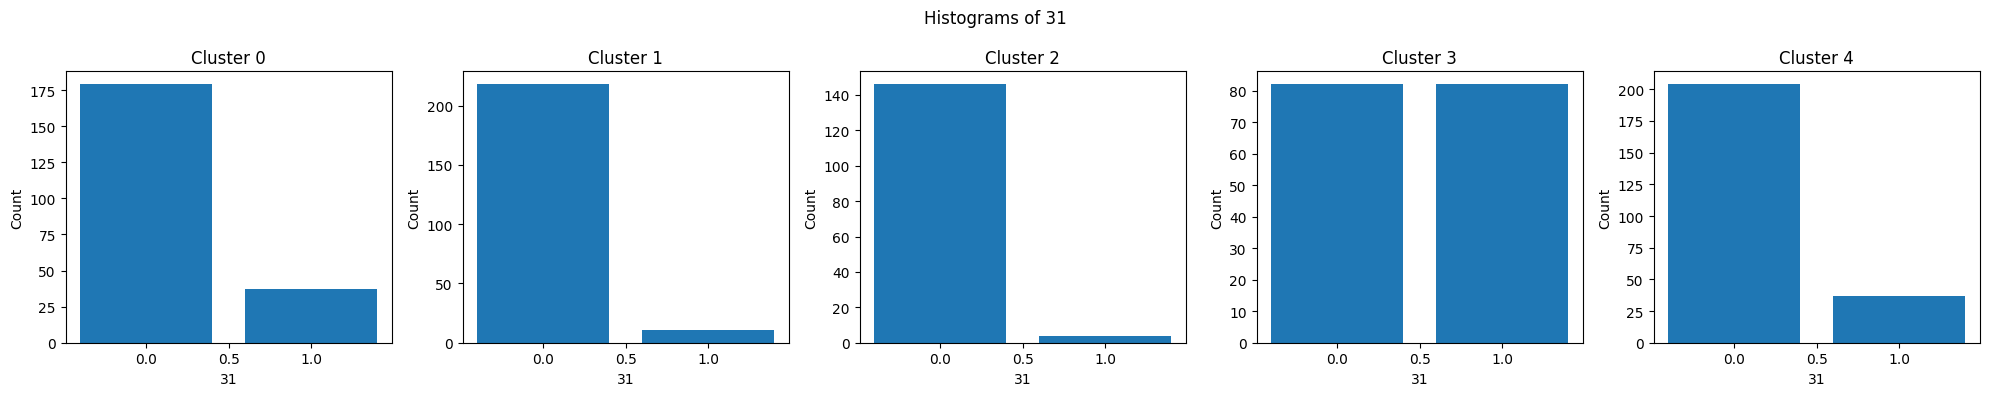

In [30]:
clusters = gmm.predict(embeddings)
df["cluster"] = clusters

top_features = ["SpoofType", "Illumination", "Environment", "24", "39", "31"]
# Create a grid of histograms for each sensitive feature
for feature in top_features:
    # Create a subplot for each cluster
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))

    # Create a histogram for each cluster
    for cluster_id, group in df_head.groupby('cluster'):
        # Count the frequency of each value of the current feature in the current cluster
        counts = group[feature].value_counts()

        # Create a bar chart of the counts in the current subplot
        axs[cluster_id].bar(counts.index, counts.values)
        axs[cluster_id].set_xlabel(feature)
        axs[cluster_id].set_ylabel("Count")
        axs[cluster_id].set_title(f"Cluster {cluster_id}")

    # Add a title to the overall plot
    plt.suptitle(f"Histograms of {feature}")

    # Adjust the layout of the subplots
    plt.tight_layout()

    # Display the overall plot
    plt.show()

# we want to assess whether there are biases in sensitive features like gender or race.

In [14]:
import functools

import numpy as np
import sklearn.metrics as skm
from fairlearn.datasets import fetch_adult
from fairlearn.metrics import MetricFrame, count, selection_rate

#the fraction of predicted labels matching the ‘good’ outcome
print("Selection Rate: ", selection_rate(df["Prediction"], df["Spoof"]))

#F-beta score is the weighted harmonic mean of precision and recall, reaching its optimal value at 1 and its worst value at 0.
print("fbeta: ", skm.fbeta_score(df["Prediction"], df["Spoof"], beta = 0.6))

Selection Rate:  0.6544230769230769
fbeta:  0.6392207609054024


We know that there are sensitive features in our data, and we want to
ensure that we\'re not harming individuals due to membership in any of
these groups. For this purpose, Fairlearn provides the
`fairlearn.metrics.MetricFrame`{.interpreted-text role="class"} class.
Let us construct an instance of this class, and then look at its
capabilities:


In [16]:
fbeta_06 = functools.partial(skm.fbeta_score, beta=0.6, zero_division=1)

metric_fns = {"selection_rate": selection_rate, "fbeta_06": fbeta_06, "count": count}

grouped_on_1 = MetricFrame(
    metrics=metric_fns, y_true=df["Spoof"], y_pred=df["Prediction"], sensitive_features=df["1"]
)

The `fairlearn.metrics.MetricFrame`{.interpreted-text role="class"}
object requires a minimum of four arguments:

1.  The underlying metric function(s) to be evaluated
2.  The true values
3.  The predicted values
4.  The sensitive feature values

These are all passed as arguments to the constructor. If more than one
underlying metric is required (as in this case), then we must provide
them in a dictionary.

The underlying metrics must have a signature `fn(y_true, y_pred)`, so we
have to use `functools.partial`{.interpreted-text role="func"} on
`fbeta_score()` to furnish `beta=0.6` (we will show how to pass in extra
array arguments such as sample weights shortly).

We will now take a closer look at the
`fairlearn.metrics.MetricFrame`{.interpreted-text role="class"} object.
First, there is the `overall` property, which contains the metrics
evaluated on the entire dataset. We see that this contains the same
values calculated above:


In [17]:
assert grouped_on_1.overall["selection_rate"] == selection_rate(df["Spoof"], df["Prediction"])
assert grouped_on_1.overall["fbeta_06"] == skm.fbeta_score(df["Spoof"], df["Prediction"], beta=0.6)
print(grouped_on_1.overall)

selection_rate        0.424538
fbeta_06              0.781687
count             26000.000000
dtype: float64


The other property in the
`fairlearn.metrics.MetricFrame`{.interpreted-text role="class"} object
is `by_group`. This contains the metrics evaluated on each subgroup
defined by the categories in the `sensitive_features=` argument. Note
that `fairlearn.metrics.count`{.interpreted-text role="func"} can be
used to display the number of data points in each subgroup. In this
case, we have results for males and females:


In [18]:
grouped_on_1.by_group

,selection_rate,fbeta_06,count
1,,,
0,0.464485,0.802781,22793.0
1,0.140630,0.000000,3207.0


We can immediately see a substantial disparity in the selection rate
between males and females.

We can also create another
`fairlearn.metrics.MetricFrame`{.interpreted-text role="class"} object
using second column as the sensitive feature:


In [21]:
grouped_on_2 = MetricFrame(
    metrics=metric_fns, y_true=df["Spoof"], y_pred=df["Prediction"], sensitive_features=df["2"]
)

The `overall` property is unchanged:


In [22]:
assert (grouped_on_1.overall == grouped_on_2.overall).all()

The `by_group` property now contains the metrics evaluated based on the
\'2\' column:


In [23]:
grouped_on_2.by_group

,selection_rate,fbeta_06,count
2,,,
0,0.494096,0.815022,20919.0
1,0.138162,0.000000,5081.0


We see that there is also a significant disparity in selection rates
when grouping by second sensitive feature.


Sample weights and other arrays
===============================

We noted above that the underlying metric functions passed to the
`fairlearn.metrics.MetricFrame`{.interpreted-text role="class"}
constructor need to be of the form `fn(y_true, y_pred)` - we do not
support scalar arguments such as `pos_label=` or `beta=` in the
constructor. Such arguments should be bound into a new function using
`functools.partial`{.interpreted-text role="func"}, and the result
passed in. However, we do support arguments which have one entry for
each sample, with an array of sample weights being the most common
example. These are divided into subgroups along with `y_true` and
`y_pred`, and passed along to the underlying metric.

To use these arguments, we pass in a dictionary as the `sample_params=`
argument of the constructor. Let us generate some random weights, and
pass these along:


In [24]:
random_weights = np.random.rand(len(df.index))

example_sample_params = {
    "selection_rate": {"sample_weight": random_weights},
    "fbeta_06": {"sample_weight": random_weights},
}


grouped_with_weights = MetricFrame(
    metrics=metric_fns,
    y_true=df["Spoof"],
    y_pred=df["Prediction"],
    sensitive_features=df["1"],
    sample_params=example_sample_params,
)

We can inspect the overall values, and check they are as expected:


In [25]:
assert grouped_with_weights.overall["selection_rate"] == selection_rate(
    df["Spoof"], df["Prediction"], sample_weight=random_weights
)
assert grouped_with_weights.overall["fbeta_06"] == skm.fbeta_score(
    df["Spoof"], df["Prediction"], beta=0.6, sample_weight=random_weights
)
print(grouped_with_weights.overall)

selection_rate        0.425192
fbeta_06              0.785506
count             26000.000000
dtype: float64


Quantifying Disparities
=======================

We suspect that our model has biases by gender, race, etc. However, there are many
cases where presenting all these numbers at once will not be useful (for
example, a high level dashboard which is monitoring model performance).
Fairlearn provides several means of aggregating metrics across the
subgroups, so that disparities can be readily quantified.

The simplest of these aggregations is `group_min()`, which reports the
minimum value seen for a subgroup for each underlying metric (we also
provide `group_max()`). This is useful if there is a mandate that \"no
subgroup should have an `fbeta_score()` of less than 0.6.\" We can
evaluate the minimum values easily:


In [26]:
grouped_on_1.group_min()

selection_rate    0.14063
fbeta_06              0.0
count              3207.0
dtype: object

As noted above, the selection rates varies greatly by first and second columnf of the df.
This can be quantified in terms of a difference between the subgroup
with the highest value of the metric, and the subgroup with the lowest
value. For this, we provide the method
`difference(method='between_groups)`:


In [27]:
grouped_on_1.difference(method="between_groups")

selection_rate        0.323855
fbeta_06              0.802781
count             19586.000000
dtype: float64

In [28]:
grouped_on_1.difference(method="to_overall")

selection_rate        0.283909
fbeta_06              0.781687
count             22793.000000
dtype: float64

In [29]:
grouped_on_1.ratio(method="between_groups")

selection_rate    0.302765
fbeta_06          0.000000
count             0.140701
dtype: float64

In [30]:
grouped_on_1.ratio(method="to_overall")

selection_rate    0.331254
fbeta_06          0.000000
count             0.123346
dtype: float64

Intersections of Features
=========================

So far we have only considered a single sensitive feature at a time, and
we have already found some serious issues in our example data. However,
sometimes serious issues can be hiding in intersections of features. For
example, the [Gender Shades
project](https://www.media.mit.edu/projects/gender-shades/overview/)
found that facial recognition algorithms performed worse for blacks than
whites, and also worse for women than men (despite overall high accuracy
score). Moreover, performance on black females was *terrible*. We can
examine the intersections of sensitive features by passing multiple
columns to the `fairlearn.metrics.MetricFrame`{.interpreted-text
role="class"} constructor:


In [33]:
grouped_on_1_and_2 = MetricFrame(
    metrics=metric_fns,
    y_true=df["Spoof"],
    y_pred=df["Prediction"],
    sensitive_features=df[["1", "2"]],
)

In [37]:
assert (grouped_on_1_and_2.overall == grouped_on_1.overall).all()
grouped_on_1_and_2.by_group

selection_rate  fbeta_06    count
1 2                                   
0 0        0.509270  0.819502  20119.0
  1        0.127524  0.000000   2674.0
1 0        0.112500  0.000000    800.0
  1        0.149979  0.000000   2407.0

In [39]:
grouped_on_1_and_2.group_min()

selection_rate    0.1125
fbeta_06             0.0
count              800.0
dtype: object

In [41]:
grouped_on_1_and_2.ratio(method="between_groups")

selection_rate    0.220904
fbeta_06          0.000000
count             0.039763
dtype: float64

Control Features
================

There is a further way we can slice up our data. We have (*completely
made up*) features for the individuals\' credit scores (in three bands)
and also the size of the loan requested (large or small). In our loan
scenario, it is acceptable that individuals with high credit scores are
selected more often than individuals with low credit scores. However,
within each credit score band, we do not want a disparity between (say)
black females and white males. To example these cases, we have the
concept of *control features*.

Control features are introduced by the `control_features=` argument to
the `fairlearn.metrics.MetricFrame`{.interpreted-text role="class"}
object:


In [45]:
cond_third_column = MetricFrame(
    metrics=metric_fns,
    y_true=df["Spoof"],
    y_pred=df["Prediction"],
    sensitive_features=df[["1", "2"]],
    control_features=df["3"],
)

In [46]:
cond_third_column.overall

,selection_rate,fbeta_06,count
3,,,
0,0.449401,0.792678,24032.0
1,0.120935,0.000000,1968.0


In [47]:
cond_third_column.by_group

selection_rate  fbeta_06    count
3 1 2                                   
0 0 0        0.529000  0.825655  19138.0
    1        0.134713  0.000000   2175.0
  1 0        0.109185  0.000000    577.0
    1        0.149393  0.000000   2142.0
1 0 0        0.124363  0.000000    981.0
    1        0.096192  0.000000    499.0
  1 0        0.121076  0.000000    223.0
    1        0.154717  0.000000    265.0

In [48]:
cond_third_column.group_min()

,selection_rate,fbeta_06,count
3,,,
0,0.109185,0.0,577.0
1,0.096192,0.0,223.0


In [49]:
cond_third_column.ratio(method="between_groups")

,selection_rate,fbeta_06,count
3,,,
0,0.206400,0.0,0.030149
1,0.621731,NaN,0.227319


In [50]:
cond_both = MetricFrame(
    metrics=metric_fns,
    y_true=df["Spoof"],
    y_pred=df["Prediction"],
    sensitive_features=df[["1", "2"]],
    control_features=df[["3", "4"]],
)

In [51]:
cond_both.overall

selection_rate  fbeta_06    count
3 4                                   
0 0        0.450830  0.793288  23927.0
  1        0.123810  0.000000    105.0
1 0        0.116613  0.000000   1878.0
  1        0.211111  0.000000     90.0

In [52]:
cond_both.by_group

selection_rate  fbeta_06    count
3 4 1 2                                   
0 0 0 0        0.530984  0.826316  19042.0
      1        0.134961  0.000000   2171.0
    1 0        0.109756  0.000000    574.0
      1        0.149533  0.000000   2140.0
  1 0 0        0.135417  0.000000     96.0
      1        0.000000  1.000000      4.0
    1 0        0.000000  1.000000      3.0
      1        0.000000  1.000000      2.0
1 0 0 0        0.116331  0.000000    894.0
      1        0.094378  0.000000    498.0
    1 0        0.122172  0.000000    221.0
      1        0.154717  0.000000    265.0
  1 0 0        0.206897  0.000000     87.0
      1        1.000000  0.000000      1.0
    1 0        0.000000  1.000000      2.0
      1             NaN       NaN      NaN

The aggregates behave similarly. By this point, we are having
significant issues with under-populated intersections. Consider:


In [53]:
def member_counts(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return len(y_true)


counts = MetricFrame(
    metrics=member_counts,
    y_true=df["Spoof"],
    y_pred=df["Prediction"],
    sensitive_features=df[["1", "2"]],
    control_features=df[["3", "4"]],
)

counts.by_group

3  4  1  2
0  0  0  0    19042.0
         1     2171.0
      1  0      574.0
         1     2140.0
   1  0  0       96.0
         1        4.0
      1  0        3.0
         1        2.0
1  0  0  0      894.0
         1      498.0
      1  0      221.0
         1      265.0
   1  0  0       87.0
         1        1.0
      1  0        2.0
         1        NaN
Name: member_counts, dtype: float64